In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sc
import matplotlib
import h5py
import ClassPIC
import Particle
import Simulation
from scipy import integrate
from scipy import optimize
import random
import matplotlib.animation as ani
from numba import jit, cuda, vectorize
from scipy.fft import rfft, rfftfreq, fftshift
from scipy.signal.windows import blackman, gaussian, boxcar, hamming
from scipy.stats import pearsonr
from multiprocessing import Pool
from IPython.display import Math

N = 3975

sim = ClassPIC.PIC(N, directory = 'C:/Projects/Plasma Research/First Idea');

sim.params()

frozent = 0.1 # time for frozen E, B field

c = 0.225 # TRISTAN-MP constant

ppc0 = 600 # TRISTAN-MP constant

c_omp = 3.5 # TRISTAN-MP constant

sigma = sim.sigma

delgam = sim.delgam

L = sim.L

simt = int(frozent*N/2) # time converted into array indices

Ex = np.load("C:/Projects/Plasma Research/First Idea/CenteredFields/ex_centered_total.npy", mmap_mode = 'r')[simt]

Ey = np.load("C:/Projects/Plasma Research/First Idea/CenteredFields/ey_centered_total.npy", mmap_mode = 'r')[simt]

Ez = np.load("C:/Projects/Plasma Research/First Idea/CenteredFields/ez_centered_total.npy", mmap_mode = 'r')[simt]

Bx = np.load("C:/Projects/Plasma Research/First Idea/CenteredFields/bx_centered_total.npy", mmap_mode = 'r')[simt] # get frozen field

By = np.load("C:/Projects/Plasma Research/First Idea/CenteredFields/by_centered_total.npy", mmap_mode = 'r')[simt]

Bz = np.load("C:/Projects/Plasma Research/First Idea/CenteredFields/bz_centered_total.npy", mmap_mode = 'r')[simt]

In [69]:
# REAL MAIN METHOD
n = 1 # number of particles

numgyro = 200

numberSim = 50
correlationSims = []

args = []

#Ex = np.zeros(((int(L/sim.istep)), int(L/sim.istep)))
#Ey = np.zeros(((int(L/sim.istep)), int(L/sim.istep)))
#Ez = np.zeros(((int(L/sim.istep)), int(L/sim.istep)))

arg = [n,1,numgyro, sim.sigma, sim.delgam, sim.mi, sim.L, sim.istep, c_omp, Ex, Ey, Ez, Bx, By, Bz]

for i in range(0, numberSim):
    args.append(arg)

with Pool(7) as p:
    correlationSims = p.starmap(Simulation.Simulation,args)
    
'''
counter = 0
vparList = []

while(counter < 30):
    vparhits0 = True
    while(vparhits0 == True):
        sim01 = Simulation.Simulation(n,1,numgyro, sim.sigma, sim.delgam, sim.mi, sim.L, sim.istep, c_omp, np.zeros(((int(L/sim.istep)), int(L/sim.istep))), np.zeros(((int(L/sim.istep)), int(L/sim.istep))), np.zeros(((int(L/sim.istep)), int(L/sim.istep))), Bx, By, Bz)
        vpar = sim01.computeVpar(0)
        hits0 = 0
        for i in range(0,len(vpar)-1):
            if np.sign(vpar[i]) != np.sign(vpar[i+1]):
                hits0 = hits0+1
                if(hits0 > 10):
                    break
        if(hits0 <= 10):
            vparhits0 = False
    vparList.append(vpar)
    counter = counter+1
    print("COUNTER = " + str(counter))
'''

'\ncounter = 0\nvparList = []\n\nwhile(counter < 30):\n    vparhits0 = True\n    while(vparhits0 == True):\n        sim01 = Simulation.Simulation(n,1,numgyro, sim.sigma, sim.delgam, sim.mi, sim.L, sim.istep, c_omp, np.zeros(((int(L/sim.istep)), int(L/sim.istep))), np.zeros(((int(L/sim.istep)), int(L/sim.istep))), np.zeros(((int(L/sim.istep)), int(L/sim.istep))), Bx, By, Bz)\n        vpar = sim01.computeVpar(0)\n        hits0 = 0\n        for i in range(0,len(vpar)-1):\n            if np.sign(vpar[i]) != np.sign(vpar[i+1]):\n                hits0 = hits0+1\n                if(hits0 > 10):\n                    break\n        if(hits0 <= 10):\n            vparhits0 = False\n    vparList.append(vpar)\n    counter = counter+1\n    print("COUNTER = " + str(counter))\n'

In [2]:
#B Fluctuations computation
BBAv = np.array([np.sqrt(np.mean(Bx[i])**2 + np.mean(By[i])**2 + np.mean(Bz[i])**2) for i in range(int(L/sim.istep))])

BBAvAv = np.mean(BBAv)

Bxt = np.load("C:/Projects/Plasma Research/First Idea/CenteredFields/bx_centered_total.npy", mmap_mode = 'r')
Byt = np.load("C:/Projects/Plasma Research/First Idea/CenteredFields/bx_centered_total.npy", mmap_mode = 'r')
Bzt = np.load("C:/Projects/Plasma Research/First Idea/CenteredFields/bx_centered_total.npy", mmap_mode = 'r')

BFluctuationsNorm = np.full(N, None)

for i in range(0, N):
    BBAv = np.array([np.sqrt(np.mean(Bxt[i][j])**2 + np.mean(Byt[i][j])**2 + np.mean(Bzt[i][j])**2) for j in range(int(L/sim.istep))])
    BBAvAv = np.mean(BBAv)
    BFluctuations = ((np.max(Bxt[i])-np.min(Bxt[i]))**2 + (np.max(Byt[i])-np.min(Byt[i]))**2 + (np.max(Bzt[i])-np.min(Bzt[i]))**2)
    BFluctuationsNorm[i] = BFluctuations/BBAvAv**2

t = np.arange(0, N, 1)*frozent/200

plt.plot(t, BFluctuationsNorm)

plt.title(r'$ \delta B^2/ {\langle} B {\rangle} ^2 $')

plt.xlabel(r'$ t \cdot s $')

plt.savefig("fluctuations.png")

plt.show()

In [32]:
# SORT FROM PASSING TO TRAPPED
trapped = []
passing = []
for i in range(0, numberSim):
    if(correlationSims[i].computeHits0(0) <= 50):
        passing.append(correlationSims[i])
    else:
        trapped.append(correlationSims[i])
        
print(len(trapped))
print(len(passing))

In [34]:
# CALCULATE <D^2> TRAPPED PARTICLES 

tmax = int(numgyro*correlationSims[0].getT())

distalongB2AvgTrapped = np.zeros(int(tmax/correlationSims[0].getdt())-2, dtype = 'float64')

for i in range(0, len(trapped)-1):
    tmax = int(numgyro*trapped[i].getT())
    distalongB = np.full(int(tmax/correlationSims[0].getdt()), None)
    vpar = trapped[i].computeVpar(0)
    distalongB = sc.integrate.cumtrapz(vpar) 
    avg = distalongB**2/numberSim
    avg = np.ndarray.astype(avg, 'float64')
    distalongB2AvgTrapped += avg

In [35]:
# CALCULATE <D^2> PASSING PARTICLES 
tmax = int(numgyro*correlationSims[0].getT())

distalongB2AvgPassing = np.zeros(int(tmax/correlationSims[0].getdt())-2, dtype = 'float64')

for i in range(0, len(passing)-1):
    tmax = int(numgyro*passing[i].getT())
    distalongB = np.full(int(tmax/correlationSims[0].getdt()), None)
    vpar = passing[i].computeVpar(0)
    distalongB = sc.integrate.cumtrapz(vpar) 
    avg = distalongB**2/numberSim
    avg = np.ndarray.astype(avg, 'float64')
    distalongB2AvgPassing += avg

In [70]:
# CALCULATE <D^2> ALL PARTICLES 
tmax = int(numgyro*correlationSims[0].getT())

distalongB2Avg = np.zeros(int(tmax/correlationSims[0].getdt())-2, dtype = 'float64')

for i in range(0, numberSim):
    tmax = int(numgyro*correlationSims[i].getT())
    distalongB = np.full(int(tmax/correlationSims[0].getdt()), None)
    vpar = correlationSims[i].computeVpar(0)
    distalongB = sc.integrate.cumtrapz(vpar) 
    avg = distalongB**2/numberSim
    avg = np.ndarray.astype(avg, 'float64')
    distalongB2Avg += avg

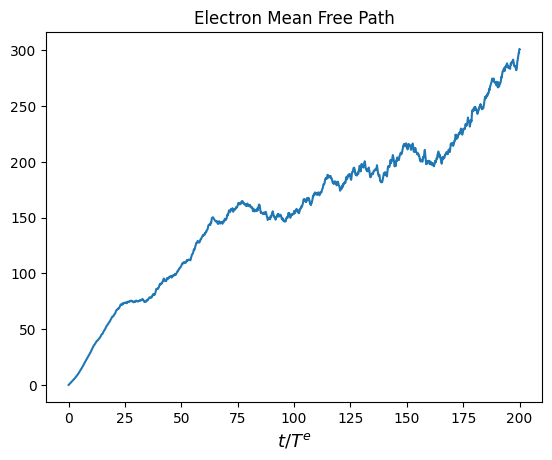

In [71]:
# MEAN FREE PATH CALCULATION & PLOTTING
t = np.arange(0, tmax, correlationSims[0].getdt())

#distderivativeTrapped = np.gradient(distalongB2AvgTrapped, 1) * c * np.sqrt(sim.delgam)
#distderivativePassing = np.gradient(distalongB2AvgPassing, 1) * c * np.sqrt(sim.delgam)
distderivative = np.gradient(distalongB2Avg, 1) * c * np.sqrt(sim.delgam)


plt.title("Electron Mean Free Path")
#plt.plot(t[:-2]/correlationSims[0].getT(), distderivativeTrapped, label = 'Trapped')
#plt.plot(t[:-2]/correlationSims[0].getT(), distderivativePassing, label = 'Passing')
plt.plot(t[:-2]/correlationSims[0].getT(), distderivative)

plt.xlabel(r'$t/T^e$', fontsize = 13)
#plt.legend()
plt.savefig("MeanFreePathTrappedPassingComparisonE4" + ".png", dpi=300, bbox_inches = "tight")
#np.savetxt('distderivativeTrappedNoE100e.txt', distderivativeTrapped)
#np.savetxt('distderivativePassingNoE100e.txt', distderivativePassing)



In [ ]:
# SIGN CHANGES METHOD/FOURIER METHOD COMPARISON
fourierList = []
hitsList = []

baseline = np.loadtxt('meanFTElectronN=163911(10,30)NE.txt')

for i in range(0, numberSim):
    #Hits 0 Method
    vpar = correlationSims[i].computeVpar(0)
    hits0 = 0
    for i in range(0,len(vpar)-1):
        if np.sign(vpar[i]) != np.sign(vpar[i+1]):
            hits0 = hits0+1
    hitsList.append(hits0)
    #Fourier
    N = len(vpar)v
    w = hamming(N)
    vparfw = np.abs(rfft(vpar*w, n=N))
    #diff = vparfw*(baseline[0]/vparfw[0])- baseline # multiply vparfw by baseline[0]/vpar[0]
    #diff = vparfw+(baseline[0]-vparfw[0]) - baseline
    logDiff = np.log(vparfw*(baseline[0]/vparfw[0])/baseline)
    wce = sim.wcis/(sim.sheartime*sim.mi)
    f = 2*np.pi*rfftfreq(N, 1)/wce
    area = sc.integrate.cumtrapz(logDiff[15:100], np.log(f[15:100]))
    fourierList.append(area[83])


In [ ]:
# SIGN CHANGES METHOD/FOURIER METHOD COMPARISON
hitsList = np.loadtxt('hits0method200e.txt')
fourierList = np.loadtxt('FTareamethod200eUpdated30.txt')

plt.scatter(hitsList, fourierList)

pear = sc.stats.pearsonr(hitsList, fourierList)

r = pear[0]

r2 = r**2

p = pear[1]

#plt.yscale('log')

plt.xscale('log')

plt.title("Hits 0 Method vs. Fourier Transform Area Method (200 e)")

plt.annotate("R = {:.5f} \nR^2 = {:.5f}\np = {:.10f}".format(r,r2,p), (0, 10))
 
plt.xlabel('Number of times the particle vpar has hit 0')

plt.ylabel('LogArea of particle FT relative to baseline')

plt.savefig("comparisonMethodsNewTest" + ".png")

In [6]:
# COMPUTE SIGN CHANGES
hitsE = np.full(numberSim, None)

for i in range(0, numberSim):
    vpar = correlationSims[i].computeVpar(0)
    hits0 = 0
    for j in range(0,len(vpar)-1):
            if np.sign(vpar[j]) != np.sign(vpar[j+1]):
                hits0 = hits0+1
    hitsE[i] = hits0

'''    
for i in range(0, numberSim):
    vpar = correlationSimsNoE[i].computeVpar(0)
    hits0 = 0
    for j in range(0,len(vpar)-1):
            if np.sign(vpar[j]) != np.sign(vpar[j+1]):
                hits0 = hits0+1
    hitsnoE[i] = hits0
'''
print(np.mean(hitsE))
#print(np.mean(hitsnoE))

34.12


[34.12 39.32]


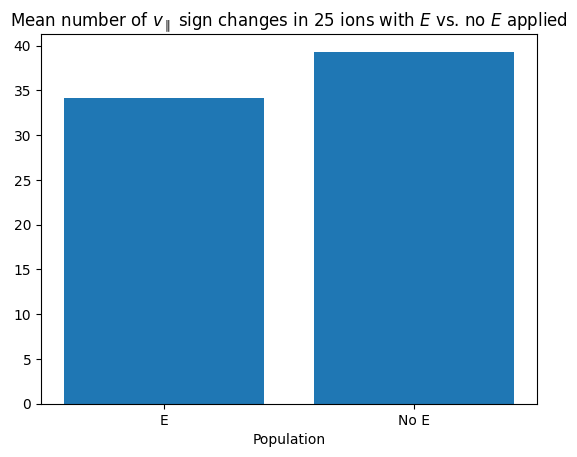

In [6]:
# SIGN CHANGES COMPARISON (E VS NO E)
treatments = []
treatments.append("E")
treatments.append("No E")
results = np.array([34.12, 39.32])
print(results)
plt.bar(treatments,results)
plt.xlabel("Population")
plt.title(r'Mean number of $v_\parallel$ sign changes in 25 ions with $E$ vs. no $E$ applied')
plt.savefig("comparison22" + ".png")

In [ ]:
# COMPUTING BASELINE

vparList = []

for i in range(0, numberSim):
    vpar = correlationSims[i].computeVpar(0)
    vparList.append(vpar)
    
fourier = []

N = len(vparList[0])

w = hamming(N)

for vpar in vparList:
    vparfw = np.abs(rfft(vpar*w, n=N))
    fourier.append(vparfw)
    
wce = (sim.wcis*sim.mi)/sim.sheartime

f = 2*np.pi*rfftfreq(N, 1)/wce

meanRFT = np.full(len(f), None)

print(N)

for i in range(0, len(f)):
    mean = 0
    for j in range(0, len(fourier)):
        mean += fourier[j][i]
    mean /= len(fourier)
    meanRFT[i] = mean

for j in range(0, len(fourier)):
    plt.loglog(f, fourier[j], label = 'Hamming window', alpha = 0.2)

plt.loglog(f, meanRFT, label = 'Hamming window')

plt.title("Mean Fourier Transform for a passing electron (defined as less/equal to 10 intersections)")

plt.xlabel('Frequency/wce')

plt.ylabel('Amplitude')

plt.savefig("meanFTElectron(10,30)NE" + ".png")

np.savetxt('meanFTElectronN=163911(10,30)NE.txt', meanRFT)

In [ ]:
# PLOTTING THE BASELINE
baseline = np.loadtxt('meanFTElectronN=81955.txt')

wce = (sim.wcis*sim.mi)/sim.sheartime

f = 2*np.pi*rfftfreq(81955, 1)/wce

plt.loglog(f, baseline, label = 'Hamming window')

plt.title("Mean Fourier Transform for a passing electron (defined as less/equal to 5 intersections)")

plt.xlabel('Frequency/wce')

plt.ylabel('Amplitude')

plt.savefig("meanFTElectron" + ".png")

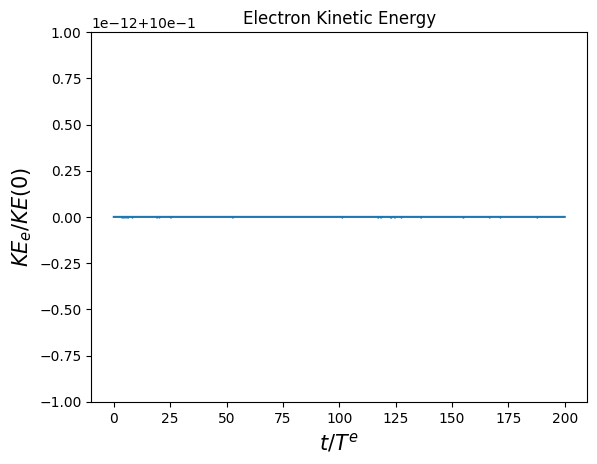

In [5]:
# ENERGY PLOTTING
t = np.arange(0, int(numgyro*sim01.getT()), sim01.getdt())

low = 1 - 10**-12
high = 1 + 10**-12
plt.ylim(low,high)
plt.plot(t/sim01.getT(), sim01.getKE()/sim01.getKE()[0])

plt.xlabel(r'$t/T^e$', fontsize = 15)

plt.ylabel(r'$KE_e/KE(0)$', fontsize = 15)

plt.title(r'Electron Kinetic Energy')

seed = str(sim01.getPtcls()[0].getx(0)) + "," + str(sim01.getPtcls()[0].gety(0)) + "," + str(sim01.getPtcls()[0].getz(0)) + "," + str(sim01.getPtcls()[0].getvx(0)) + "," + str(sim01.getPtcls()[0].getvy(0)) + "," + str(sim01.getPtcls()[0].getvz(0))
plt.savefig("KEComparisonNoE100Electron.png", dpi=300, bbox_inches = "tight")

In [ ]:
# PARTICLE TRAJECTORY PLOTTING
fig, ax = plt.subplots()

L = sim.L/sim.R_Li

ptcls = sim01.getPtcls()

print("The initial Larmor radius should be around: " + str(sim.R_Li))
plt.xlabel('Particle x-position')
plt.ylabel('Particle y-position')
plt.xlim(0, L)
plt.ylim(0, L)

xp = ptcls[0].getxp()
yp = ptcls[0].getyp()

line = ax.plot(xp[0], yp[0], 'o', color = 'black', linewidth = 0.5)[0]
line2 = ax.plot(xp[0], yp[0], 'o', color = 'white', markersize = 0.015)[0]
ax.set(xlim=[0, L], ylim=[0, L], xlabel='Particle x-position', ylabel='Particle y-position')

#plt.plot(xp, yp, 'o', color = 'black', markersize = 0.1)

tail = 80000

def buildmelinegraph(i=int):
    line.set_xdata(xp[i])
    line.set_ydata(yp[i])
    if i < tail:
        line2.set_xdata(xp[:i])
        line2.set_ydata(yp[:i])
    else:
        line2.set_xdata(xp[i-tail:i])
        line2.set_ydata(yp[i-tail:i])
    return (line, line2)

B2 = np.sqrt(Bx**2 + By**2 + Bz**2)


plt.imshow(B2, extent = [0, L, 0, L])

#cax = plt.axes([0.8, 0.1, 0.075, 0.8])
#plt.colorbar(cax=cax)

plt.plot(xp[0:40000]/sim.R_Li, yp[0:40000]/sim.R_Li, 'o', color = 'black', markersize = 0.015, linewidth = 0.5)
    
#animator = ani.FuncAnimation(fig = fig, func = buildmelinegraph, frames = range(0, 2000000, 200), interval = 1, repeat = True)
#animator.save("animationCorrect.mp4")

plt.show()

In [ ]:
# LARMOR ORBIT

ptcls = sim01.getPtcls()

tmax = int(numgyro*sim01.getT())

timeSteps = int(tmax/sim01.getdt())-1

bx = sim01.getBint()[0]

by = sim01.getBint()[1]

bz = sim01.getBint()[2]

ex = sim01.getEint()[0]

ey = sim01.getEint()[1]

ez = sim01.getEint()[2]

RLi = np.full(int(tmax/sim01.getdt()), None)

vperpa = np.full(int(tmax/sim01.getdt()), None)

ba = np.full(int(tmax/sim01.getdt()), None)

ea = np.full(int(tmax/sim01.getdt()), None)

vmag = np.full(int(tmax/sim01.getdt()), None)

c = 0.225

for i in range(0, int(tmax/sim01.getdt())-1):
    v = np.array([ptcls[0].getvx(i),ptcls[0].getvy(i), ptcls[0].getvz(i)])
    b = np.array(([bx[i], by[i], bz[i]]))
    e = np.array(([ex[i], ey[i], ez[i]]))
    bhat = b/np.linalg.norm(b)
    dot = np.dot(v,bhat)
    vperp = v - (dot*bhat)
    RLi[i] = (ptcls[0].getm() * np.linalg.norm(vperp) * c**2)/np.linalg.norm(b)
    vperpa[i] = np.linalg.norm(vperp)
    ba[i] = np.linalg.norm(b)
    ea[i] = np.linalg.norm(e)
    if i == 0:
        vmag0 = np.linalg.norm(v)
        vmag[i] = 1
    else: 
        vmag[i] = np.linalg.norm(v)/vmag0
    
    
print(RLi[0])
    
t = np.arange(0, tmax, sim01.getdt())

#plt.plot(t[:int(tmax/sim01.getdt())-1], RLi[:int(tmax/sim01.getdt())-1]/sim.R_Li)

plt.plot(t[110000:200000], vperpa[110000:200000])


plt.title("Larmor Radius vs. Time")